### Introduction
The goal of this notebook is to build a regression model for assessing a value of real estates based on gathered variables. The main idea is to utilize Apache Spark on Databricks and to explore its capabilities.
### Import of libraries
We start from importing the necessary libraries.

In [1]:
from pyspark import SparkContext
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
sns.set(style="whitegrid")

### RDDs
First we decide to use RDDs for initial data analysis. For that we need to get (or create) a spark context.

In [2]:
sc = SparkContext.getOrCreate()

We import our data from a csv file.

In [3]:
lines = sc.textFile("/FileStore/tables/real_estate-1.csv")

Let's see the first two lines.

In [4]:
lines.take(2)

Out[164]: ['No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area',
 '1,2012.917,32,84.87882,10,24.98298,121.54024,37.9']

The first line of the file is head column. To skip it we use zipWithIndex() and filter() methods.

In [5]:
lines = lines.zipWithIndex().filter(lambda row: row[1] > 0).keys()

Now, we split and convert each of the line-strings into separate fields.

In [6]:
#process csv to list
def extractFields(line):
    fields = line.split(',')
    return float(fields[1]), float(fields[2]), float(fields[3]), int(fields[4]), float(fields[5]), float(fields[6]), float(fields[7])

lines_ex = lines.map(extractFields)

The map is only a transformation of RDD into another RDD with lazy evaluation. To split string we need to perform an action. Here we are interested in some basic statistics of column number 6 and 7, the x- and y- coordinates of a real estate location.

In [7]:
print('x_coor min: ', lines_ex.map(lambda x: x[5]).min())
print('x_coor max: ', lines_ex.map(lambda x: x[5]).max())
x_mean = lines_ex.map(lambda x: x[5]).mean()
print('x_coor mean: ', x_mean)
print('y_coor min: ', lines_ex.map(lambda x: x[6]).min())
print('y_coor max: ', lines_ex.map(lambda x: x[6]).max())
y_mean = lines_ex.map(lambda x: x[6]).mean()
print('y_coor mean: ', y_mean)

x_coor min: 121.47353
x_coor max: 121.56627
x_coor mean: 121.5333610869565
y_coor min: 7.6
y_coor max: 117.5
y_coor mean: 37.98019323671496

Running a separate min(), max() and mean() calls for each of the coordinates is not efficient. It is more beneficial to run all of the operations in a single .reduce() method.

In [8]:
x_coor = lines_ex.map(lambda x: [x[5], x[5], x[5], x[6], x[6], x[6], 1])
x_coor = x_coor.reduce(lambda x, y: [
                                    min(x[0], y[0]), max(x[1], y[1]), x[2]+y[2],
                                    min(x[3], y[3]), max(x[4], y[4]), x[5]+y[5],
                                    x[6]+y[6]
                                    ])
x_coor[2] = x_coor[2]/x_coor[-1]
x_coor[-2] = x_coor[-2]/x_coor[-1]
x_coor

Out[168]: [121.47353, 121.56627, 121.53336108695655, 7.6, 117.5, 37.98019323671499, 414]

### Data visualization
For visualization purposes (if size our data set is substantial) it may be more beneficial to sample only part of it, that is sufficiently big to be representative. The only thing that we have to keep in mind is that we may not include some of the outliers into our random sample, so separate check for outliers have to be done. In our case we do a random sample with 100% of our data and we transform it into a numpy array.

In [9]:
dat_vis = np.array(lines_ex.map(lambda x: [x[0], x[1], x[2], x[3], x[4], x[5], x[6]]).sample(False, 1.0).collect())

 Now we transform it into pandas DataFrame to do visualizations with seaborn library.

In [10]:
dat_vis = pd.DataFrame(data={'time': dat_vis[:,0],
                  'age': dat_vis[:,1],
                  'dist': dat_vis[:,2],
                  'stores': dat_vis[:,3],
                  'x_coor': dat_vis[:,4],
                  'y_coor': dat_vis[:,5],
                  'y': dat_vis[:,6]})

Let's check our sampled data.

In [11]:
dat_vis

Out[171]:

,time,age,dist,stores,x_coor,y_coor,y
0,2012.917,32.0,84.87882,10.0,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9.0,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5.0,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5.0,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5.0,24.97937,121.54245,43.1
...,...,...,...,...,...,...,...
409,2013.000,13.7,4082.01500,0.0,24.94155,121.50381,15.4
410,2012.667,5.6,90.45606,9.0,24.97433,121.54310,50.0
411,2013.250,18.8,390.96960,7.0,24.97923,121.53986,40.6
412,2013.000,8.1,104.81010,5.0,24.96674,121.54067,52.5


Now we may visually investigate our data. Let's check how our estate cost depends on each of the features. First, we start with a date of transaction.

Out[172]:

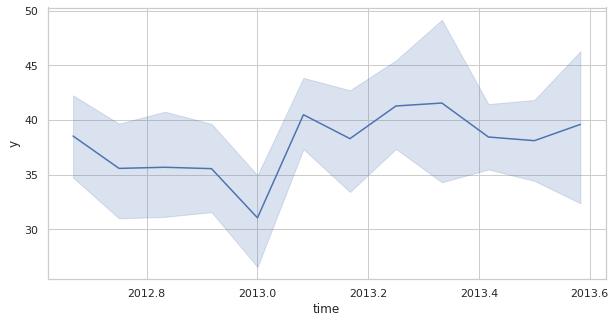

<matplotlib.axes._subplots.AxesSubplot at 0x7fcb52fc1100>

In [12]:
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.lineplot(x='time', y='y', data=dat_vis)

Out[173]:

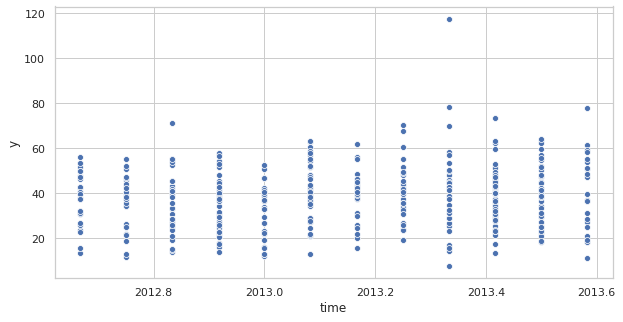

<matplotlib.axes._subplots.AxesSubplot at 0x7fcb60025af0>

In [13]:
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.scatterplot(x='time', y='y', data=dat_vis)

And the age of the property.

Out[174]:

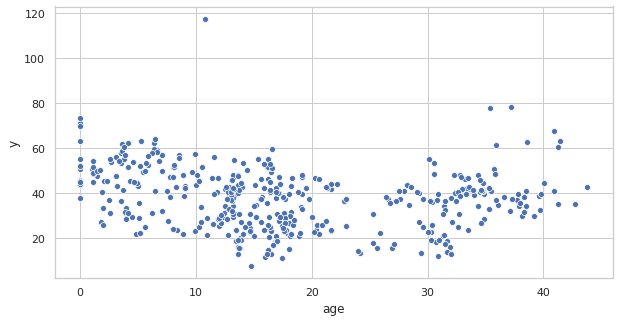

<matplotlib.axes._subplots.AxesSubplot at 0x7fcb6016c6a0>

In [14]:
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.scatterplot(x='age', y='y', data=dat_vis)

Distance to the nearest MRT station.

Out[175]:

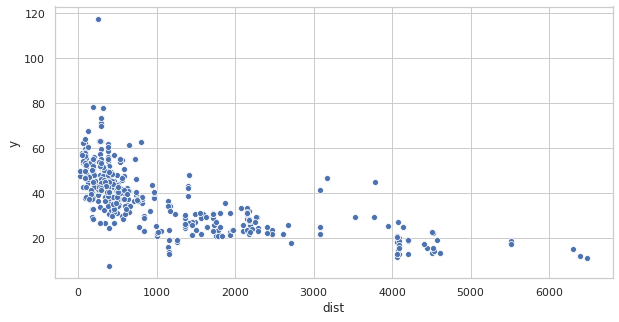

<matplotlib.axes._subplots.AxesSubplot at 0x7fcb60157400>

In [15]:
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.scatterplot(x='dist', y='y', data=dat_vis)

And the number of convenience stores in the living circle.

Out[176]:

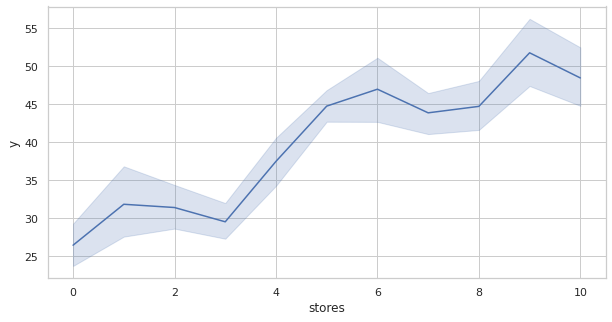

<matplotlib.axes._subplots.AxesSubplot at 0x7fcb601a1dc0>

In [16]:
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.lineplot(x='stores', y='y', data=dat_vis)

Finally, let's see how the price depends on x- and y- coordinates.

Out[177]:

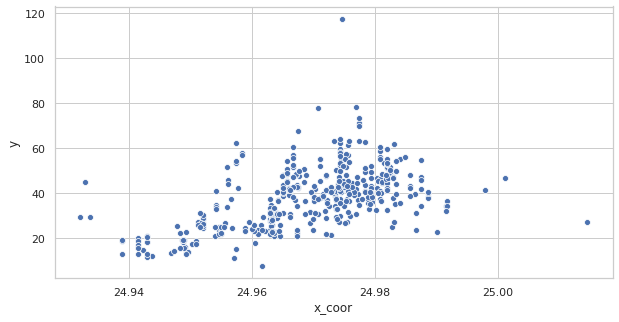

<matplotlib.axes._subplots.AxesSubplot at 0x7fcb52f5d880>

In [17]:
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.scatterplot(x='x_coor', y='y', data=dat_vis)

Out[178]:

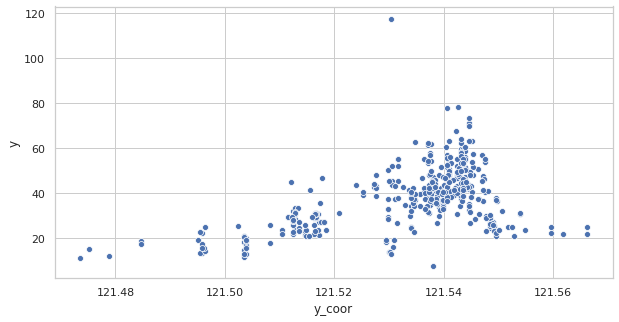

<matplotlib.axes._subplots.AxesSubplot at 0x7fcb52f1e130>

In [18]:
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
sns.scatterplot(x='y_coor', y='y', data=dat_vis)

We also check histograms of each of the variables.

Out[179]:

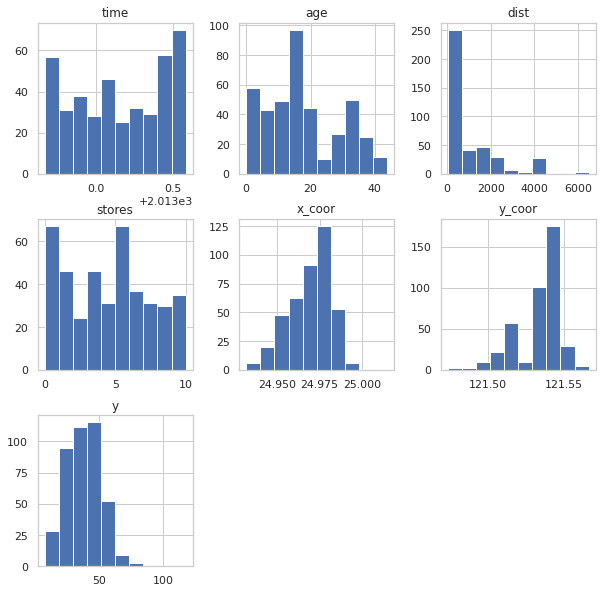

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb52e8e4c0>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7fcb52ea1d30>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7fcb52e57520>],
 [<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb52dffca0>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7fcb52e35460>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7fcb52dddb20>],
 [<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb52dddc10>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7fcb52dbdb50>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7fcb52d663d0>]],
 dtype=object)

In [19]:
dat_vis.hist(figsize = (10,10))

Clearly, our 'y' is right-skewed.   
Moreover, we plot pairplots to check how particular variables correlate.

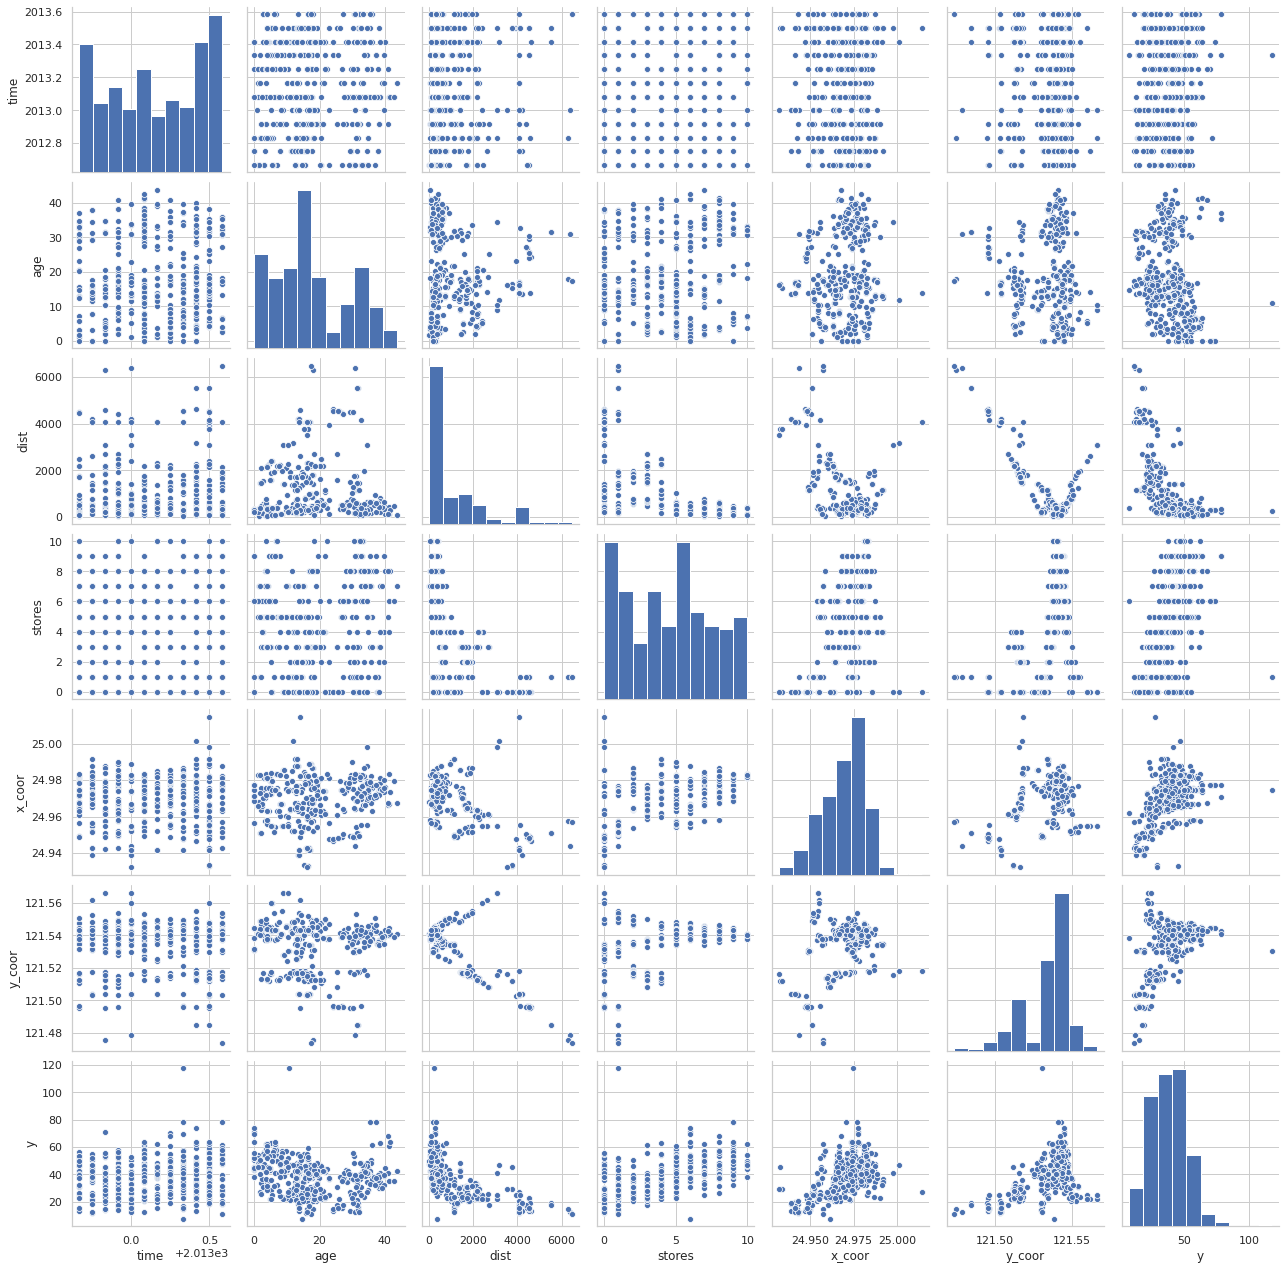

In [20]:
g = sns.pairplot(data=dat_vis)
plt.show()

And we plot a heatmap with Person's correlation of features.

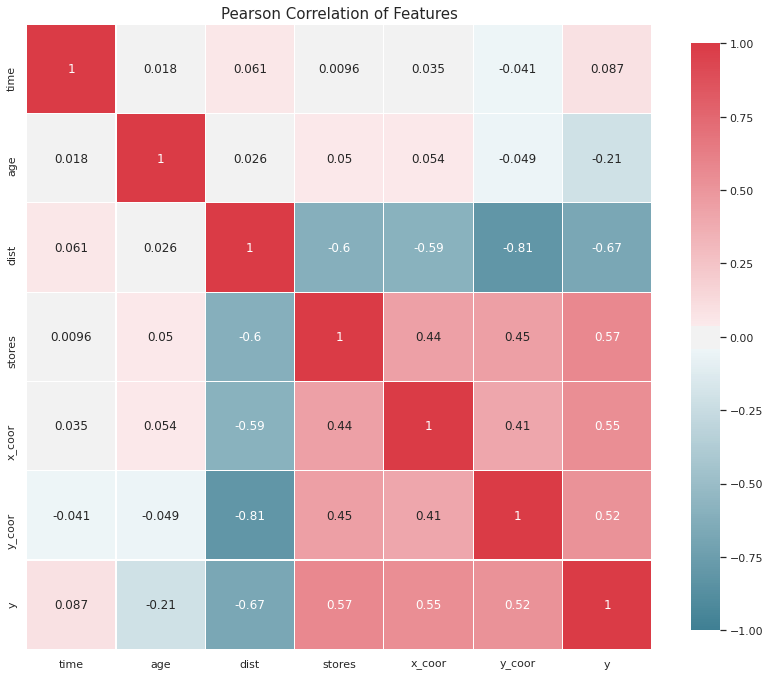

In [21]:
#%% Heatmap of data
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmin = -1.0, vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
correlation_heatmap(dat_vis)

### DataFrames
Now, we are going to build our ML models. Spark MLlib is currently highly optimized for DataFrame structures instead of RDD. We could convert our RDD into Row() object and DataFrame but instead decide to obtain SparkSession() object and we import our dataset from the .csv file with defined StructType.

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

#we get our SparkSession
spark = SparkSession.builder.getOrCreate()
#we define schema explicitly instead of infering it
schema = StructType([
                     StructField("number", IntegerType(), True),
                     StructField("time", FloatType(), True),
                     StructField("age", FloatType(), True),
                     StructField("dist", FloatType(), True),
                     StructField("stores", FloatType(), True),
                     StructField("x_coor", FloatType(), True),
                     StructField("y_coor", FloatType(), True),
                     StructField("y", FloatType(), True),
            ])

df = spark.read.option("header", "true").schema(schema).csv("/FileStore/tables/real_estate-1.csv")

Let's see our data.

In [23]:
df.show()

+------+--------+----+--------+------+--------+---------+----+
number| time| age| dist|stores| x_coor| y_coor| y|
+------+--------+----+--------+------+--------+---------+----+
 1|2012.917|32.0|84.87882| 10.0|24.98298|121.54024|37.9|
 2|2012.917|19.5|306.5947| 9.0|24.98034|121.53951|42.2|
 3|2013.583|13.3|561.9845| 5.0|24.98746|121.54391|47.3|
 4| 2013.5|13.3|561.9845| 5.0|24.98746|121.54391|54.8|
 5|2012.833| 5.0|390.5684| 5.0|24.97937|121.54245|43.1|
 6|2012.667| 7.1| 2175.03| 3.0|24.96305|121.51254|32.1|
 7|2012.667|34.5|623.4731| 7.0|24.97933|121.53642|40.3|
 8|2013.417|20.3|287.6025| 6.0|24.98042|121.54228|46.7|
 9| 2013.5|31.7|5512.038| 1.0|24.95095|121.48458|18.8|
 10|2013.417|17.9| 1783.18| 3.0|24.96731|121.51486|22.1|
 11|2013.083|34.8|405.2134| 1.0|24.97349|121.53372|41.4|
 12|2013.333| 6.3|90.45606| 9.0|24.97433| 121.5431|58.1|
 13|2012.917|13.0|492.2313| 5.0|24.96515|121.53737|39.3|
 14|2012.667|20.4|2469.645| 4.0|24.96108|121.51046|23.8|
 15| 2013.5|13.2|1164.838| 4.0|24.99156|121.53406|34.3|
 16|2013.583|35.7|579.2083| 2.0| 24.9824|121.54619|50.5|
 17| 2013.25| 0.0|292.9978| 6.0|24.97744|121.54458|70.1|
 18| 2012.75|17.7|350.8515| 1.0|24.97544|121.53119|37.4|
 19|2013.417|16.9|368.1363| 8.0| 24.9675|121.54451|42.3|
 20|2012.667| 1.5|23.38284| 7.0|24.96772|121.54102|47.7|
+------+--------+----+--------+------+--------+---------+----+
only showing top 20 rows

Data looks correctly (there may be problems in output visualization due to export between databricks and jupyter notebook).

We decide to drop the first column which is simply a row number.

In [24]:
df = df.drop('number')
df.show()

+--------+----+--------+------+--------+---------+----+
 time| age| dist|stores| x_coor| y_coor| y|
+--------+----+--------+------+--------+---------+----+
2012.917|32.0|84.87882| 10.0|24.98298|121.54024|37.9|
2012.917|19.5|306.5947| 9.0|24.98034|121.53951|42.2|
2013.583|13.3|561.9845| 5.0|24.98746|121.54391|47.3|
 2013.5|13.3|561.9845| 5.0|24.98746|121.54391|54.8|
2012.833| 5.0|390.5684| 5.0|24.97937|121.54245|43.1|
2012.667| 7.1| 2175.03| 3.0|24.96305|121.51254|32.1|
2012.667|34.5|623.4731| 7.0|24.97933|121.53642|40.3|
2013.417|20.3|287.6025| 6.0|24.98042|121.54228|46.7|
 2013.5|31.7|5512.038| 1.0|24.95095|121.48458|18.8|
2013.417|17.9| 1783.18| 3.0|24.96731|121.51486|22.1|
2013.083|34.8|405.2134| 1.0|24.97349|121.53372|41.4|
2013.333| 6.3|90.45606| 9.0|24.97433| 121.5431|58.1|
2012.917|13.0|492.2313| 5.0|24.96515|121.53737|39.3|
2012.667|20.4|2469.645| 4.0|24.96108|121.51046|23.8|
 2013.5|13.2|1164.838| 4.0|24.99156|121.53406|34.3|
2013.583|35.7|579.2083| 2.0| 24.9824|121.54619|50.5|
 2013.25| 0.0|292.9978| 6.0|24.97744|121.54458|70.1|
 2012.75|17.7|350.8515| 1.0|24.97544|121.53119|37.4|
2013.417|16.9|368.1363| 8.0| 24.9675|121.54451|42.3|
2012.667| 1.5|23.38284| 7.0|24.96772|121.54102|47.7|
+--------+----+--------+------+--------+---------+----+
only showing top 20 rows

With DataFrames we may easily do SQL-based operations like filtering. Let's first see estates that are older than 30 and which have distance bigger than 4000. For that we use the .filter() method.

In [25]:
filtered = df.filter((df['age'] > 30) & (df.dist > 4000))
filtered.show()

+--------+----+--------+------+--------+---------+----+
 time| age| dist|stores| x_coor| y_coor| y|
+--------+----+--------+------+--------+---------+----+
 2013.5|31.7|5512.038| 1.0|24.95095|121.48458|18.8|
 2013.5|30.3|4510.359| 1.0|24.94925|121.49542|22.6|
 2013.0|30.9|6396.283| 1.0|24.94375|121.47883|12.2|
2013.417|31.5|5512.038| 1.0|24.95095|121.48458|17.4|
 2013.5|32.6|4136.271| 1.0|24.95544| 121.4963|24.7|
+--------+----+--------+------+--------+---------+----+

We may also obtain the basic statistics of 'y' with .agg(), the aggregating method.

In [26]:
filtered.agg(func.min('y').alias("Min"), func.max('y').alias("Max"), func.round(func.avg('y'),2).alias("Avg")).show()

+----+----+-----+
 Min| Max| Avg|
+----+----+-----+
12.2|24.7|19.14|
+----+----+-----+

And as easily we may run a chosen function on grouped subsets of data and than we may transform it into pandas.

In [27]:
vals = df.groupBy("stores").avg("y").toPandas()

To nicely visualize them.

Out[188]:

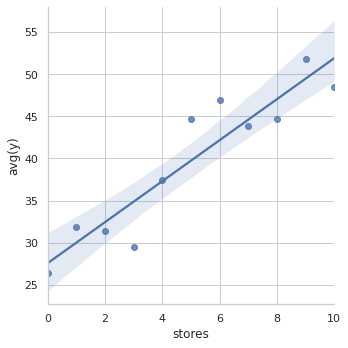

<seaborn.axisgrid.FacetGrid at 0x7fcb50efbb80>

In [28]:
sns.lmplot(x='stores', y='avg(y)', data=vals)

If we want we may also use SQL module to run full SQL queries.

In [29]:
df.createOrReplaceTempView("table")
sqlDF = spark.sql("SELECT ROUND(AVG(age),2) AS AverageAge, stores FROM table \
                  WHERE dist < 100 AND time < 2013  \
                  GROUP BY stores ORDER BY stores")
sqlDF.show()

+----------+------+
AverageAge|stores|
+----------+------+
 2.48| 7.0|
 3.5| 8.0|
 5.77| 9.0|
 32.45| 10.0|
+----------+------+

And at any point we may transform our RDDs into a DataFrame object.

In [30]:
df = lines_ex.toDF()

In [31]:
df.show(n=5)
print('Number of rows: ', df.count())

+--------+----+--------+---+--------+---------+----+
 _1| _2| _3| _4| _5| _6| _7|
+--------+----+--------+---+--------+---------+----+
2012.917|32.0|84.87882| 10|24.98298|121.54024|37.9|
2012.917|19.5|306.5947| 9|24.98034|121.53951|42.2|
2013.583|13.3|561.9845| 5|24.98746|121.54391|47.3|
 2013.5|13.3|561.9845| 5|24.98746|121.54391|54.8|
2012.833| 5.0|390.5684| 5|24.97937|121.54245|43.1|
+--------+----+--------+---+--------+---------+----+
only showing top 5 rows

Number of rows: 414

### Modeling with MLlib
Now, we are going to do a simple linear regression on our data. We are going to scale it with StandardScaler(). Moreover, for modeling purposes we need to transform it into features and labels vectors.

In [32]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["_1", "_2", "_3", "_4", "_5", "_6"],
    outputCol="feat")

output = assembler.transform(df)

final_data = output.select("feat", "_7")
final_data = final_data.selectExpr("feat as feat", "_7 as label")
final_data.show()

+--------------------+-----+
 feat|label|
+--------------------+-----+
[2012.917,32.0,84...| 37.9|
[2012.917,19.5,30...| 42.2|
[2013.583,13.3,56...| 47.3|
[2013.5,13.3,561....| 54.8|
[2012.833,5.0,390...| 43.1|
[2012.667,7.1,217...| 32.1|
[2012.667,34.5,62...| 40.3|
[2013.417,20.3,28...| 46.7|
[2013.5,31.7,5512...| 18.8|
[2013.417,17.9,17...| 22.1|
[2013.083,34.8,40...| 41.4|
[2013.333,6.3,90....| 58.1|
[2012.917,13.0,49...| 39.3|
[2012.667,20.4,24...| 23.8|
[2013.5,13.2,1164...| 34.3|
[2013.583,35.7,57...| 50.5|
[2013.25,0.0,292....| 70.1|
[2012.75,17.7,350...| 37.4|
[2013.417,16.9,36...| 42.3|
[2012.667,1.5,23....| 47.7|
+--------------------+-----+
only showing top 20 rows

 We randomly split our data and perform the scaling. To prevent data leakage we train our scaler only on the train part of our dataset.

In [33]:
train_data, test_data = final_data.randomSplit([0.7,0.3], seed=7)

scaler = StandardScaler(inputCol='feat',
                        outputCol='features',
                        withStd=True, withMean=True)
scaler = scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

Let's see a head of our dataset.

In [34]:
train_data.head(5)

Out[194]: [Row(feat=DenseVector([2012.667, 1.5, 23.3828, 7.0, 24.9677, 121.541]), label=47.7, features=DenseVector([-1.7505, -1.4416, -0.8599, 0.994, -0.0894, 0.4874])),
 Row(feat=DenseVector([2012.667, 3.1, 383.8624, 5.0, 24.9808, 121.5439]), label=56.2, features=DenseVector([-1.7505, -1.303, -0.555, 0.3115, 0.9637, 0.6865])),
 Row(feat=DenseVector([2012.667, 7.1, 2175.03, 3.0, 24.963, 121.5125]), label=32.1, features=DenseVector([-1.7505, -0.9565, 0.9601, -0.3711, -0.464, -1.4752])),
 Row(feat=DenseVector([2012.667, 12.9, 492.2313, 5.0, 24.9652, 121.5374]), label=42.5, features=DenseVector([-1.7505, -0.454, -0.4633, 0.3115, -0.2956, 0.2358])),
 Row(feat=DenseVector([2012.667, 15.6, 289.3248, 5.0, 24.982, 121.5435]), label=46.1, features=DenseVector([-1.7505, -0.2201, -0.635, 0.3115, 1.0583, 0.6569]))]

 Now we train a linear regression model with default hyperparameters.

In [35]:
lr = LinearRegression(featuresCol='features', labelCol='label')
# Fit the model to the data and call this model lrModel
lrModel = lr.fit(train_data)
# Print the coefficients and intercept for linear regression
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

Coefficients: [1.7706500057618546,-2.6049233685966935,-5.276863581557029,3.2175981105208975,2.91569989611694,-0.2538605362804863] Intercept: 38.293006993006706

Let's see the importance of each of the features.

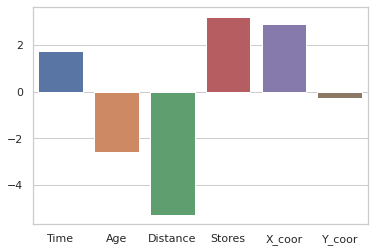

In [36]:
ax = sns.barplot(x=['Time', 'Age', 'Distance', 'Stores', 'X_coor', 'Y_coor'], y=lrModel.coefficients.array)

We may evaluate our data on the test dataset.

In [37]:
test_results = lrModel.evaluate(test_data)

In [38]:
print("RMSE: {}".format(test_results.rootMeanSquaredError))
print("MSE: {}".format(test_results.meanSquaredError))
print("R2: {}".format(test_results.r2))

RMSE: 8.064290499860586
MSE: 65.0327812661417
R2: 0.660913064903999

The results are far from satisfying but the model has not been tuned and the data exhibits nonlinear patters. First we try to tune the hyperparameters with grid seach and cross validation on 5 folds.

In [39]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol='features', labelCol='label', solver='normal')
elPar = [0., 1e-4, 1e-3, 1e-2, 1e-1, 0.9, 1e0]
regPar = [0., 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]

paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, elPar) \
    .addGrid(lr.regParam, regPar) \
    .build()

crossval_LR = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=5)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel_LR = crossval_LR.fit(train_data)

/databricks/spark/python/pyspark/ml/util.py:800: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

We may plot an average metric for each of paramaters combination.

In [40]:
for vals, metric in zip(cvModel_LR.getEstimatorParamMaps(), cvModel_LR.avgMetrics):
  val = list(vals.values())
  print("ElasticNet param: {}, Regularization param: {}, AvgMetric: {}".format(val[0], val[1], metric))

ElasticNet param: 0.0, Regularization param: 0.0, AvgMetric: 9.078348278819618
ElasticNet param: 0.0, Regularization param: 0.0001, AvgMetric: 9.078342593513216
ElasticNet param: 0.0, Regularization param: 0.001, AvgMetric: 9.0782914643486
ElasticNet param: 0.0, Regularization param: 0.01, AvgMetric: 9.077783969979036
ElasticNet param: 0.0, Regularization param: 0.1, AvgMetric: 9.073066784126997
ElasticNet param: 0.0, Regularization param: 1.0, AvgMetric: 9.048456316005435
ElasticNet param: 0.0, Regularization param: 10.0, AvgMetric: 9.27296168015448
ElasticNet param: 0.0, Regularization param: 100.0, AvgMetric: 11.585292258078173
ElasticNet param: 0.0001, Regularization param: 0.0, AvgMetric: 9.078348278819618
ElasticNet param: 0.0001, Regularization param: 0.0001, AvgMetric: 9.078342567343881
ElasticNet param: 0.0001, Regularization param: 0.001, AvgMetric: 9.07829143114902
ElasticNet param: 0.0001, Regularization param: 0.01, AvgMetric: 9.077784109179603
ElasticNet param: 0.0001, Regularization param: 0.1, AvgMetric: 9.073066508852696
ElasticNet param: 0.0001, Regularization param: 1.0, AvgMetric: 9.048452653317254
ElasticNet param: 0.0001, Regularization param: 10.0, AvgMetric: 9.2731982652227
ElasticNet param: 0.0001, Regularization param: 100.0, AvgMetric: 11.58752623250557
ElasticNet param: 0.001, Regularization param: 0.0, AvgMetric: 9.078348278819618
ElasticNet param: 0.001, Regularization param: 0.0001, AvgMetric: 9.078342569781261
ElasticNet param: 0.001, Regularization param: 0.001, AvgMetric: 9.078291126765247
ElasticNet param: 0.001, Regularization param: 0.01, AvgMetric: 9.077783770699966
ElasticNet param: 0.001, Regularization param: 0.1, AvgMetric: 9.073065014347405
ElasticNet param: 0.001, Regularization param: 1.0, AvgMetric: 9.048418832246888
ElasticNet param: 0.001, Regularization param: 10.0, AvgMetric: 9.275332927226708
ElasticNet param: 0.001, Regularization param: 100.0, AvgMetric: 11.607677839036421
ElasticNet param: 0.01, Regularization param: 0.0, AvgMetric: 9.078348278819618
ElasticNet param: 0.01, Regularization param: 0.0001, AvgMetric: 9.07834227262892
ElasticNet param: 0.01, Regularization param: 0.001, AvgMetric: 9.078291168628418
ElasticNet param: 0.01, Regularization param: 0.01, AvgMetric: 9.077780007032533
ElasticNet param: 0.01, Regularization param: 0.1, AvgMetric: 9.073046445041212
ElasticNet param: 0.01, Regularization param: 1.0, AvgMetric: 9.048095095115158
ElasticNet param: 0.01, Regularization param: 10.0, AvgMetric: 9.29740454616475
ElasticNet param: 0.01, Regularization param: 100.0, AvgMetric: 11.813681756057132
ElasticNet param: 0.1, Regularization param: 0.0, AvgMetric: 9.078348278819618
ElasticNet param: 0.1, Regularization param: 0.0001, AvgMetric: 9.078342298234112
ElasticNet param: 0.1, Regularization param: 0.001, AvgMetric: 9.07828752347045
ElasticNet param: 0.1, Regularization param: 0.01, AvgMetric: 9.077746059109359
ElasticNet param: 0.1, Regularization param: 0.1, AvgMetric: 9.072899560553195
ElasticNet param: 0.1, Regularization param: 1.0, AvgMetric: 9.046201629016071
ElasticNet param: 0.1, Regularization param: 10.0, AvgMetric: 9.593417988094362
ElasticNet param: 0.1, Regularization param: 100.0, AvgMetric: 13.292699481334182
ElasticNet param: 0.9, Regularization param: 0.0, AvgMetric: 9.078348278819618
ElasticNet param: 0.9, Regularization param: 0.0001, AvgMetric: 9.07833897711506
ElasticNet param: 0.9, Regularization param: 0.001, AvgMetric: 9.078255829306627
ElasticNet param: 0.9, Regularization param: 0.01, AvgMetric: 9.077474511890378
ElasticNet param: 0.9, Regularization param: 0.1, AvgMetric: 9.069721305473076
ElasticNet param: 0.9, Regularization param: 1.0, AvgMetric: 9.151407990873974
ElasticNet param: 0.9, Regularization param: 10.0, AvgMetric: 13.287052376783691
ElasticNet param: 0.9, Regularization param: 100.0, AvgMetric: 13.292699481334182
ElasticNet param: 1.0, Regularization param: 0.0, AvgMetric: 9.078348278819618
ElasticNet param: 1.0, Regulari

Or we may simply build a heatmap out of it.

Out[202]:

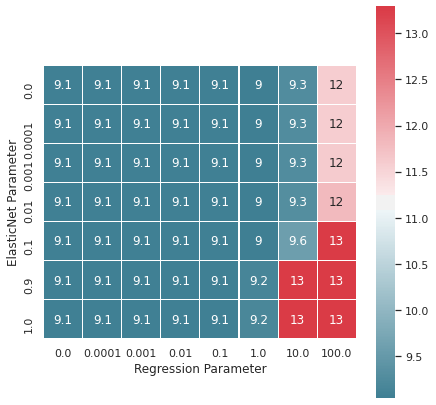

Text(0.5, 129.22999999999996, 'Regression Parameter')

In [41]:
_ , ax = plt.subplots(figsize =(7, 8))
colormap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(
          np.array(cvModel_LR.avgMetrics).reshape((len(elPar),len(regPar))),
          cmap = colormap,
          square=True, 
          cbar_kws={'shrink':.9 }, 
          ax=ax,
          annot=True,
          linewidths=0.1,
          linecolor='white',
          xticklabels=regPar,
          yticklabels=elPar,
          annot_kws={'fontsize':12 }
           )
ax.set_ylabel('ElasticNet Parameter')
ax.set_xlabel('Regression Parameter')

Finally, we pick the best model and compare the importance of features.

In [42]:
best_model_LR = cvModel_LR.bestModel
print('Best ElNet parameter: ', best_model_LR._java_obj.getElasticNetParam())
print('Best Reg parameter: ',best_model_LR._java_obj.getRegParam())

Best ElNet parameter: 0.1
Best Reg parameter: 1.0

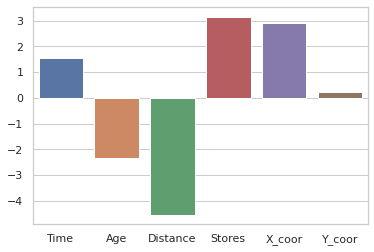

In [43]:
ax = sns.barplot(x=['Time', 'Age', 'Distance', 'Stores', 'X_coor', 'Y_coor'], y=best_model_LR.coefficients.array)

If we want we may also check the number of iterations required for convergence.

In [44]:
summary_LR = best_model_LR.summary
summary_LR.totalIterations

Out[205]: 13

Or look up the parameter of our model.

In [45]:
best_model_LR.params

Out[206]: [Param(parent='LinearRegression_52d392d5e170', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'),
 Param(parent='LinearRegression_52d392d5e170', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'),
 Param(parent='LinearRegression_52d392d5e170', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'),
 Param(parent='LinearRegression_52d392d5e170', name='featuresCol', doc='features column name.'),
 Param(parent='LinearRegression_52d392d5e170', name='fitIntercept', doc='whether to fit an intercept term.'),
 Param(parent='LinearRegression_52d392d5e170', name='labelCol', doc='label column name.'),
 Param(parent='LinearRegression_52d392d5e170', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber.'),
 Param(parent='LinearRegression_52d392d5e170', name='maxBlockSizeInMB', doc='maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0.'),
 Param(parent='LinearRegression_52d392d5e170', name='maxIter', doc='max number of iterations (>= 0).'),
 Param(parent='LinearRegression_52d392d5e170', name='predictionCol', doc='prediction column name.'),
 Param(parent='LinearRegression_52d392d5e170', name='regParam', doc='regularization parameter (>= 0).'),
 Param(parent='LinearRegression_52d392d5e170', name='solver', doc='The solver algorithm for optimization. Supported options: auto, normal, l-bfgs.'),
 Param(parent='LinearRegression_52d392d5e170', name='standardization', doc='whether to standardize the training features before fitting the model.'),
 Param(parent='LinearRegression_52d392d5e170', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0).'),
 Param(parent='LinearRegression_52d392d5e170', name='weightCol', doc='weight column name. If this is not set or empty, we treat all instance weights as 1.0.')]

In [46]:
print(cvModel_LR.getEstimatorParamMaps()[np.argmin(cvModel_LR.avgMetrics)])

{Param(parent='LinearRegression_52d392d5e170', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.1, Param(parent='LinearRegression_52d392d5e170', name='regParam', doc='regularization parameter (>= 0).'): 1.0}

Finally, we may evaluate our results on test dataset.

In [47]:
test_results_LR = best_model_LR.evaluate(test_data)

In [48]:
print("RMSE: {}".format(test_results_LR.rootMeanSquaredError))
print("MSE: {}".format(test_results_LR.meanSquaredError))
print("R2: {}".format(test_results_LR.r2))

RMSE: 8.131425821108616
MSE: 66.12008588419192
R2: 0.6552437580825432

For a tuned model results on a test dataset are even slightly worse what indicates that linear models are unsuitable for this dataset. 
#### Random Forest Regression
Now we will try a model that easily handles the nonlinearity. Random Forest are not suitable for extrapolation so 'time' feature should be removed, but here we are only playing with Spark library and we leave it for convenience. Moreover, Random Forests do not require feature scaling but since we have already scaled our data we are going to reuse it. We start from also building a grid search on 5 folds cross validation data set.

In [49]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(featuresCol='features', labelCol='label',
                          numTrees=500)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [3, 5, 10, 15, 20, 30]) \
    .build()

crossval_RF = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=5)

cvModel_RF = crossval_RF.fit(train_data)

We pick the best model.

In [50]:
best_model_RF = cvModel_RF.bestModel

And we check its parameters.

In [51]:
print(best_model_RF) 

RandomForestRegressionModel: uid=RandomForestRegressor_044327e1dd5c, numTrees=500, numFeatures=6

In [52]:
best_model_RF.getMaxDepth()

Out[213]: 10

For random forest we may also check the features importance.

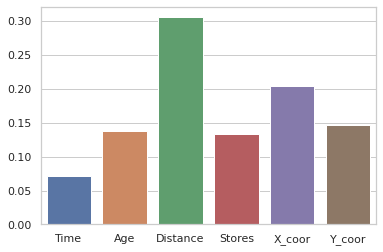

In [53]:
ax = sns.barplot(x=['Time', 'Age', 'Distance', 'Stores', 'X_coor', 'Y_coor'], y=best_model_RF.featureImportances.toArray())

Finally, we may check the accuracy on our test set.

In [54]:
predictions = best_model_RF.transform(test_data)
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction")

rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print("RMSE: {}".format(rmse))
print("MSE: {}".format(mse))
print("R2: {}".format(r2))

RMSE: 5.839123739174189
MSE: 34.095366041387564
R2: 0.8222236086653488

The results have improved when compared to the linear model.